# Import Packages

In [3]:
import numpy as np
import pandas as pd
#import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [5]:
import dagshub
dagshub.init(repo_owner='kbs.kartik', repo_name='delivery-time-prediction', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=2fbc0379-a178-4308-9144-4bef728a1b84&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=01054d4df2e27a13d99feb255804e026236b2409071b491cc1ad64d6266ecf4e




Accessing as kbs.kartik

Initialized MLflow to track repo "kbs.kartik/delivery-time-prediction"

Repository kbs.kartik/delivery-time-prediction initialized!

In [6]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [21]:
# load the data

df = pd.read_csv(r'C:\Users\KARTIK\Documents\delivery-time-prediction\data\raw\swiggy.csv')

In [22]:
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0,No,Metropolitian,(min) 32
45589,0xd641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 36
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0,No,Metropolitian,(min) 16
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1,No,Metropolitian,(min) 26


In [23]:
# String NaNs in the data

(df == "NaN ").sum().sum()

np.int64(8515)

In [50]:
import numpy as np
import pandas as pd


columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]


def change_column_names(data: pd.DataFrame):
    return (
        data.rename(str.lower,axis=1).rename({
            "delivery_person_id" : "rider_id",
            "delivery_person_age": "age",
            "delivery_person_ratings": "ratings",
            "delivery_location_latitude": "delivery_latitude",
            "delivery_location_longitude": "delivery_longitude",
            "time_orderd": "order_time",
            "time_order_picked": "order_picked_time",
            "weatherconditions": "weather",
            "road_traffic_density": "traffic",
            "city": "city_type",
            "time_taken(min)": "time_taken"},
            axis=1)
    )


def data_cleaning(data: pd.DataFrame):
    minors_data = data.loc[data['age'].astype('float') < 18]
    minor_index = minors_data.index.tolist()
    six_star_data = data.loc[data['ratings'] == "6"]
    six_star_index = six_star_data.index.tolist()

    return (
        data
        .drop(columns="id")
        .drop(index=minor_index)                                                # Minor riders in data dropped
        .drop(index=six_star_index)                                             # six star rated drivers dropped
        .replace("NaN ",np.nan)                                                 # missing values in the data
        .assign(
            # city column out of rider id
            city_name = lambda x: x['rider_id'].str.split("RES").str.get(0),
            # convert age to float
            age = lambda x: x['age'].astype(float),
            # convert ratings to float
            ratings = lambda x: x['ratings'].astype(float),
            # absolute values for location based columns
            restaurant_latitude = lambda x: x['restaurant_latitude'].abs(),
            restaurant_longitude = lambda x: x['restaurant_longitude'].abs(),
            delivery_latitude = lambda x: x['delivery_latitude'].abs(),
            delivery_longitude = lambda x: x['delivery_longitude'].abs(),
            # order date to datetime and feature extraction
            order_date = lambda x: pd.to_datetime(x['order_date'],
                                                  dayfirst=True),
            order_day = lambda x: x['order_date'].dt.day,
            order_month = lambda x: x['order_date'].dt.month,
            order_day_of_week = lambda x: x['order_date'].dt.day_name().str.lower(),
            is_weekend = lambda x: (x['order_date']
                                    .dt.day_name()
                                    .isin(["Saturday","Sunday"])
                                    .astype(int)),
            # time based columns
            order_time = lambda x: pd.to_datetime(x['order_time'],
                                                  format='mixed'),
            order_picked_time = lambda x: pd.to_datetime(x['order_picked_time'],
                                                         format='mixed'),
            # time taken to pick order
            pickup_time_minutes = lambda x: (
                                            (x['order_picked_time'] - x['order_time'])
                                            .dt.seconds / 60
                                            ),
            # hour in which order was placed
            order_time_hour = lambda x: x['order_time'].dt.hour,
            # time of the day when order was placed
            order_time_of_day = lambda x: (
                                x['order_time_hour'].pipe(time_of_day)),
            # categorical columns
            weather = lambda x: (
                                x['weather']
                                .str.replace("conditions ","")
                                .str.lower()
                                .replace("nan",np.nan)),
            traffic = lambda x: x["traffic"].str.rstrip().str.lower(),
            type_of_order = lambda x: x['type_of_order'].str.rstrip().str.lower(),
            type_of_vehicle = lambda x: x['type_of_vehicle'].str.rstrip().str.lower(),
            festival = lambda x: x['festival'].str.rstrip().str.lower(),
            city_type = lambda x: x['city_type'].str.rstrip().str.lower(),
            # multiple deliveries column
            multiple_deliveries = lambda x: x['multiple_deliveries'].astype(float),
            # target column modifications
            time_taken = lambda x: (x['time_taken']
                                     .str.replace("(min) ","")
                                     .astype(int)))
        .drop(columns=["order_time","order_picked_time"])
    )
    
    
    
def clean_lat_long(data: pd.DataFrame, threshold=1):
    location_columns = ['restaurant_latitude',
                        'restaurant_longitude',
                        'delivery_latitude',
                        'delivery_longitude']

    return (
        data
        .assign(**{
            col: (
                np.where(data[col] < threshold, np.nan, data[col].values)
            )
            for col in location_columns
        })
    )
    
    
# extract day, day name, month and year
def extract_datetime_features(ser):
    date_col = pd.to_datetime(ser,dayfirst=True)

    return (
        pd.DataFrame(
            {
                "day": date_col.dt.day,
                "month": date_col.dt.month,
                "year": date_col.dt.year,
                "day_of_week": date_col.dt.day_name(),
                "is_weekend": date_col.dt.day_name().isin(["Saturday","Sunday"]).astype(int)
            }
        ))
    
    
def time_of_day(ser):

    return(
        pd.cut(ser,bins=[0,6,12,17,20,24],right=True,
               labels=["after_midnight","morning","afternoon","evening","night"])
    )


def drop_columns(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    df = data.drop(columns=columns)
    return df


def calculate_haversine_distance(df):
    location_columns = ['restaurant_latitude',
                        'restaurant_longitude',
                        'delivery_latitude',
                        'delivery_longitude']
    
    lat1 = df[location_columns[0]]
    lon1 = df[location_columns[1]]
    lat2 = df[location_columns[2]]
    lon2 = df[location_columns[3]]

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return (
        df.assign(
            distance = distance)
    )

def create_distance_type(data: pd.DataFrame):
    return(
        data
        .assign(
                distance_type = pd.cut(data["distance"],bins=[0,5,10,15,25],
                                        right=False,labels=["short","medium","long","very_long"])
    ))


def perform_data_cleaning(data: pd.DataFrame):
    
    cleaned_data = (
        data
        .pipe(change_column_names)
        .pipe(data_cleaning)
        .pipe(clean_lat_long)
        .pipe(calculate_haversine_distance)
        .pipe(create_distance_type)
        .pipe(drop_columns,columns=columns_to_drop)
    )
    
    return cleaned_data,cleaned_data.dropna()
    
    

if __name__ == "__main__":
    # data path for data
    #DATA_PATH = "swiggy.csv"
    
    # read the data from path
    #df = pd.read_csv(DATA_PATH)
    #print('swiggy data loaded successfuly')
    
    df_with_nans, df_without_nans = perform_data_cleaning(df)

In [51]:
df_without_nans

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,33,0,10.0,night,16.600272,very_long
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


# Experiment with and without NANs



In [52]:
import mlflow

In [53]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/kbs.kartik/delivery-time-prediction.mlflow/")

In [37]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Drop Vs Keep missing Values")

2025/07/05 13:04:36 INFO mlflow.tracking.fluent: Experiment with name 'Exp 1 - Drop Vs Keep missing Values' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/37a7591ee7554319bb1bb5f4ba17c821', creation_time=1751700879140, experiment_id='1', last_update_time=1751700879140, lifecycle_stage='active', name='Exp 1 - Drop Vs Keep missing Values', tags={}>

In [54]:
temp_df = df_without_nans.copy()#.dropna()

In [55]:
temp_df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,33,0,10.0,night,16.600272,very_long
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [56]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [57]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [58]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [59]:
y_train

8720     49
25245    31
34118    11
26036    24
37194    31
         ..
20275    30
7601     24
13632    15
1045     26
19002    28
Name: time_taken, Length: 30156, dtype: int64

In [60]:
# missing data in training data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [61]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'is_weekend', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [62]:
len(X_train.columns)

15

In [63]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [64]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [65]:
for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium', 'short', 'long', 'very_long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [66]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [67]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [68]:
# transform the data

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_trans

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8720,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25245,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34118,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
26036,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37194,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20275,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7601,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13632,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [69]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [70]:
pt.lambdas_

array([0.32446096])

In [71]:
y_train_pt

,x0
0,2.028672
1,0.554539
2,-2.024267
3,-0.173699
4,0.554539
...,...
30151,0.457580
30152,-0.173699
30153,-1.350937
30154,0.047111


In [72]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train_trans,y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [73]:
# get the predictions
y_pred_train = rf.predict(X_train_trans)
y_pred_test = rf.predict(X_test_trans)

In [74]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [75]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.16 minutes
The test error is 3.09 minutes


In [76]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [77]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,X_train_trans,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80749859, 0.81045676, 0.81110906, 0.80941208, 0.81095031])

In [78]:
# mean score

scores.mean()

np.float64(0.809885359362567)

<Axes: >

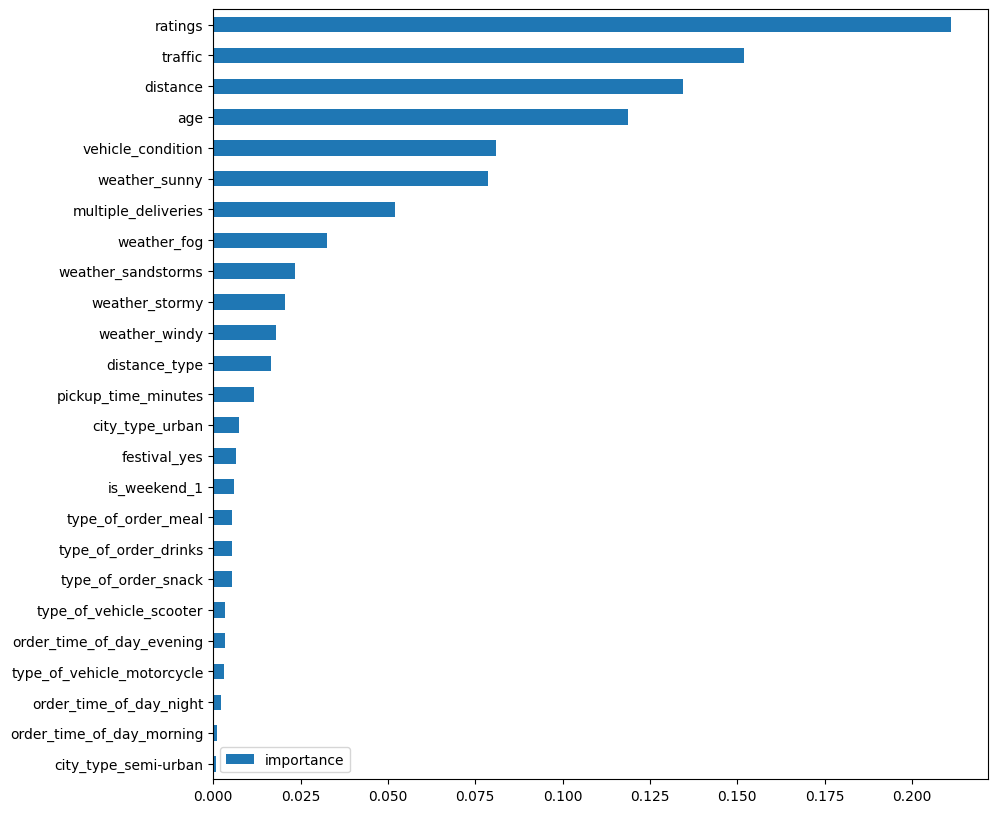

In [79]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=X_train_trans.columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [80]:
# log experiment

with mlflow.start_run(run_name="Drop Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Drop Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())


🏃 View run Drop Missing Values at: https://dagshub.com/kbs.kartik/delivery-time-prediction.mlflow/#/experiments/1/runs/312a59d5b0c744a684eb41967763c40e
🧪 View experiment at: https://dagshub.com/kbs.kartik/delivery-time-prediction.mlflow/#/experiments/1


In [81]:
from sklearn.feature_selection import RFECV

In [82]:
# feature selection using rfecv

rfecv = RFECV(
    estimator=rf,
    step=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

In [83]:
# select features

rfecv.fit(X_train_trans,y_train_pt.values.ravel())

,estimator,RandomForestRegressor()
,step,10
,min_features_to_select,1
,cv,5
,scoring,'r2'
,verbose,2
,n_jobs,-1
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None


In [84]:
# list of selected features

rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_motorcycle',
       'type_of_vehicle_scooter', 'festival_yes', 'city_type_semi-urban',
       'city_type_urban', 'is_weekend_1', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night', 'traffic',
       'distance_type', 'vehicle_condition', 'multiple_deliveries'],
      dtype=object)

In [85]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(X_train_trans),y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [86]:
# get the predictions
y_pred_train = rf.predict(rfecv.transform(X_train_trans))
y_pred_test = rf.predict(rfecv.transform(X_test_trans))

In [87]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [88]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.09 minutes


In [89]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [90]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,rfecv.transform(X_train_trans),y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80844327, 0.80984433, 0.81090004, 0.80921631, 0.81248829])

In [91]:
# mean score

scores.mean()

np.float64(0.8101784481966601)

In [92]:
rf.feature_importances_

array([0.11818982, 0.21175732, 0.0114299 , 0.1316975 , 0.03261308,
       0.02308225, 0.02025867, 0.07723251, 0.01765391, 0.00532896,
       0.00555317, 0.00531812, 0.00315269, 0.00341811, 0.0066158 ,
       0.00073421, 0.00734644, 0.00585566, 0.00327793, 0.00119629,
       0.00228995, 0.15127245, 0.01844565, 0.07959287, 0.05668672])

<Axes: >

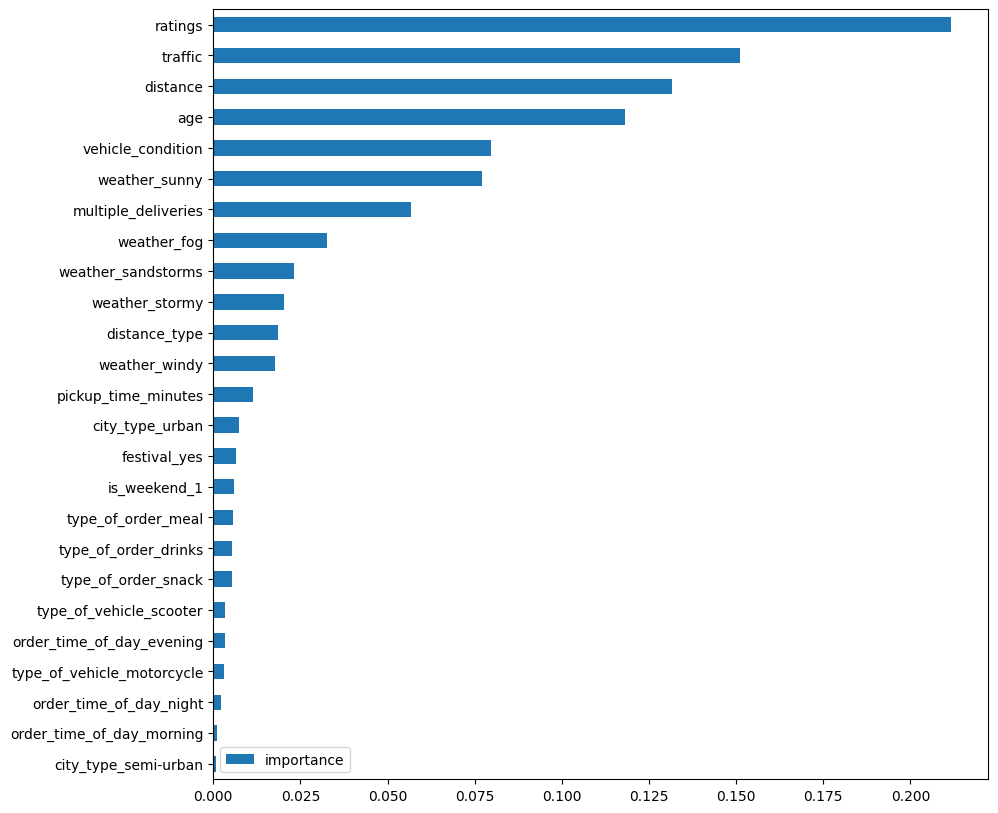

In [93]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=rfecv.transform(X_train_trans).columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

# Impute Missing values

In [94]:
temp_df = df_with_nans.copy()

In [95]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45589,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,0,15.0,evening,NaN,NaN
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [96]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [97]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (36401, 15)
The shape of test data is (9101, 15)


In [98]:
# missing values in train data

X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [99]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [100]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(17.0)

# Imputation Pipeline

In [101]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [102]:
X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [103]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'is_weekend',
 'order_time_of_day']

In [104]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [105]:
simple_imputer.fit_transform(X_train)

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
11047,1.0,no,metropolitian,windy,snack,electric_scooter,0,evening,26.0,4.7,jam,2,10.0,9.177684,medium
15692,1.0,no,metropolitian,windy,drinks,motorcycle,0,afternoon,21.0,4.9,medium,2,5.0,6.081536,medium
14499,1.0,no,metropolitian,stormy,meal,scooter,1,missing,NaN,NaN,low,2,NaN,1.554563,short
29258,1.0,no,metropolitian,windy,buffet,motorcycle,0,evening,32.0,4.7,medium,0,15.0,20.852271,very_long
22554,0.0,no,urban,sandstorms,meal,scooter,0,night,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.0,no,metropolitian,sandstorms,meal,scooter,0,evening,29.0,4.7,jam,2,5.0,12.464367,long
44821,0.0,no,urban,cloudy,buffet,motorcycle,0,morning,36.0,4.8,low,0,10.0,1.520432,short
38234,0.0,no,metropolitian,fog,buffet,scooter,0,evening,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,windy,meal,scooter,1,afternoon,25.0,4.9,medium,2,5.0,7.760938,medium


In [106]:
simple_imputer.fit_transform(X_train).isna().sum()

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
is_weekend                0
order_time_of_day         0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [107]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

In [108]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [109]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [110]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'low' 'high' nan]
distance_type ['medium', 'short', 'very_long', 'long', NaN]
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [111]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [112]:
preprocessor.fit_transform(X_train)

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,city_type_nan,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11047,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15692,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14499,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29258,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22554,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44821,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38234,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [113]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


age                    1470
ratings                1510
pickup_time_minutes    1298
distance               2931
multiple_deliveries     795
dtype: int64

In [116]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [117]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [118]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt.values.ravel())

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [119]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [120]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [121]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.30 minutes


In [122]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.80


In [123]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_pipe,X_train,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\KARTIK\Documents\delivery-time-prediction\.venv\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\KARTIK\Do

array([       nan,        nan, 0.78363854, 0.77793683, 0.78134489])

In [124]:
# mean score

scores.mean()

np.float64(nan)

In [125]:
# log experiment

with mlflow.start_run(run_name="Impute Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Impute Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Impute Missing Values at: https://dagshub.com/kbs.kartik/delivery-time-prediction.mlflow/#/experiments/1/runs/e4562ea6dac94fbdae5e02fc5e4a7ec4
🧪 View experiment at: https://dagshub.com/kbs.kartik/delivery-time-prediction.mlflow/#/experiments/1
